## Analysis of a Buck-Boost Converter

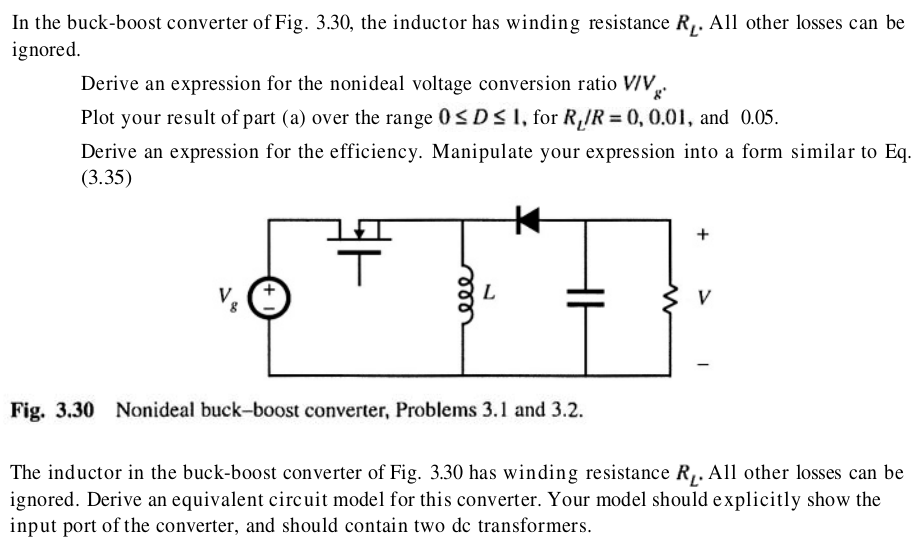

### Import what is needed

In [1]:
from IPython.display import display, Latex
from functools import wraps
from orderedset import OrderedSet
import sympy
from sympy.core.symbol import symbols, Symbol
from sympy.solvers.solveset import nonlinsolve
from sympy import solveset
from sympy import Eq
from sympy.utilities.lambdify import lambdify
from sympy.printing import latex, pprint
from sympy import Symbol, simplify
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, EngFormatter

from math import log10
from PyLTSpice import LTSpice_RawRead
from sympy.solvers import solve
import sys
import logging
from ipywidgets import FloatSlider, interact, interactive
from converter6 import * #works acceptably with converter3

Found Numpy. WIll be used for storing data


In [2]:
#logformat = '{asctime}\n{message}'
logformat = '{message}'
logger = logging.getLogger(__name__)
if logger.hasHandlers():
    #handlers somehow stay alive even after restarting iPython
    #console and clearing variables
    logger.handlers.clear()

logger.setLevel('DEBUG')
print(logger)
print(__name__)
# Use FileHandler() to log to a file
file_handler = logging.FileHandler('Problem3-1.log', mode='w')
formatter = logging.Formatter(fmt=logformat, style='{' )
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

<Logger __main__ (DEBUG)>
__main__


### Define Symbols

In [3]:
def make_symbols():
    global R, C, L, D, s, Vc, Vg, VL, iin, iL, iC, iR, fs, M, delta_iL, delta_vC, Ts, Rl
    global eta, Pin, Pout
    
    R = variable('R', 'ohms', None, real=True, positive=True)
    Rl = variable('R_L', 'ohms', None, real=True, positive=True)
    C = variable('C', 'F', None, real=True, positive=True)
    L = variable('L', 'H', real=True, positive=True)
    D = variable('D', '%', real=True, positive=True)
    
    fs = variable('f_s', 'Hz', real=True, positive=True)
    

    Vc = variable('V_c', 'V', real=True)
    Vg = variable('V_g', 'V', real= True)
    VL = variable('V_L', 'V', real= True)

    iin = variable('i_in', 'A', real=True)
    iL = variable('i_L', 'A', real=True)
    iC = variable('i_C', 'A', real=True)
    iR = variable('i_R', 'A', real=True)
    delta_iL = variable('\Delta i_L', 'A', 'delta_iL', real=True)
    delta_vC = variable('\Delta v_C', 'V', 'detla_vC', real=True)
    M = variable('M', real=True)
    eta = variable('eta', real=True)
    Pin = variable('P_in', 'Watts', real=True)
    Pout = variable('P_out', 'Watts', real=True)
    
    return
make_symbols()

### Part (a) - finding average inductor current and capacitor voltage as function of D, Vg, R

In [4]:
buckboost = converter()
buckboost.equations.add( D*(Vg-iL*Rl) + (1-D)*(Vc-iL*Rl) ) #VLavg must equal 0 in steady state
buckboost.equations.add(D*(-Vc/R) + (1-D)*(-Vc/R-iL)) #iCavg must equal 0 in steady state
buckboost.equations.add(M - Vc/Vg)
buckboost.equations.add(eta - Pout/Pin)
buckboost.equations.add(R - Vc/iR)
buckboost.equations.add(Pin - Vg*iin)
buckboost.equations.add(Pout - Vc*iR)
buckboost.showequations()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [6]:
#myprint(Vc, *buckboost.solver(given={}, want=Vc))
myprint(M, *buckboost.solver(given={}, want=M))
#myprint(eta, *buckboost.solver(given={}, want=eta))
#buckboost.solver(given={}, want=Vc)
#buckboost.solver(given={}, want=M)
#buckboost.solver(given={}, want=eta)

<IPython.core.display.Latex object>

A note on polarity - For 0 < D < 1, Vc is always opposite polarity of Vg. 

In [ ]:

print(f' Vc computation test1: {buckboost.computesym(Vc, {M:-2, Vg:5})}')
print(f' Vc computation test2: {buckboost.computesym(Vc, {Vg:10, M:3})}')
print(f' M computation test1: {buckboost.computesym(M, {D:.3, R:10,Rl:1e-3})}')
print(f' M computation test2: {buckboost.computesym(M, {Vc:-10, Vg:5})}')


In [5]:
ans =buckboost.solver(given={}, want=iL)
myprint(iL, *ans)

<IPython.core.display.Latex object>

The inductor current is positive, from the switch node to ground. The output voltage and load current are negative, with respect to how they were drawn. 

In [7]:
print(f' iL computation test1: {buckboost.computesym(iL, {R:2, Vc:5, D:.9})}')
print(f' iL computation test2: {buckboost.computesym(iL, {D:.5, Vc:5, Vg:-10, Rl:5e-3})}')
print(f' iL computation test3: {buckboost.computesym(iL, {Vc:5, Vg:-10, Rl:5e-3})}')

 iL computation test1: -25.000000000000007
 iL computation test2: -500.0
 iL computation test3: None


### Part (B) - plotting
- plot output voltage (same as capacitor voltage) as function of D
- plot average inductor current as function of D, for a few different loads.
- Note that iR = Vc/R

In [ ]:
%matplotlib notebook

In [ ]:
duty = np.linspace(0, .99, 100)
fig, ax = plt.subplots(subplot_kw={'title':' M(D) of Buck-Boost'})
given1 = {D:duty, Rl:5e-3, R:.5}
M1 = buckboost.computesym(M, given1)
given2 = {D:duty, Rl:1e-3, R:.5}
M2 = buckboost.computesym(M, given2)
ax.plot(duty, M1, label= f'Rl/R = {given1[Rl]/given1[R]}')
ax.plot(duty, M2, label= f'Rl/R = {given2[Rl]/given2[R]}')
ax.set_xlabel('Duty Cycle')
ax.set_ylabel('Conversion Ratio')
ax.legend()
#plot again, but zoom in 
fig, ax = plt.subplots(subplot_kw={'title':'M(D) of Buck-Boost'})
ax.plot(duty, M1, label= f'Rl/R = {given1[Rl]/given1[R]}')
ax.plot(duty, M2, label= f'Rl/R = {given2[Rl]/given2[R]}')
ax.set_xlabel('Duty Cycle')
ax.set_ylabel('Conversion Ratio')
ax.set_ylim(bottom=-1, top=0)
ax.set_xlim(left=0, right=.6)
ax.legend()
ax.grid()

load_currents = [-1*el for el in [.1, .2, .5, 1, 5]]
fig, ax = plt.subplots(subplot_kw={'title':'Inductor Current of Buck Boost'})
for i in load_currents:    
    #il = i/(D-1)
    il = buckboost.computesym(iL, {iR :i, D:duty})
    ax.plot(duty, il, label='load: {:.1f}A'.format(i))
ax.legend()
ax.set_xlabel('Duty Cycle')
ax.set_xlim(left=.3, right=.5)
ax.set_ylim(bottom=0, top=10)
ax.set_ylabel('inductor current [A]')
